# Stock Forecasting using skforecast

https://joaquinamatrodrigo.github.io/skforecast/0.4.3/

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

# Yahoo finance is used to fetch data 
# ==============================================================================
import yfinance as yf
yf.pdr_override()

In [2]:
symbol = '^GSPC' # input
start = '2010-01-01' # input 
end = '2022-07-18'  # input
df = yf.download(symbol, start, end)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-07-11,3880.939941,3880.939941,3847.219971,3854.429932,3854.429932,3023830000
2022-07-12,3851.949951,3873.409912,3802.360107,3818.800049,3818.800049,0
2022-07-13,3779.669922,3829.439941,3759.070068,3801.780029,3801.780029,3166580000
2022-07-14,3763.989990,3796.409912,3721.560059,3790.379883,3790.379883,3447500000
2022-07-15,3818.000000,3863.620117,3817.179932,3863.159912,3863.159912,3537130000


In [5]:
data = df.rename(columns={'Adj Close': 'y'})
data = data.resample('M').mean()
data = data.sort_index()
data.head()

,Open,High,Low,Close,y,Volume
Date,,,,,,
2010-01-31,1125.527909,1131.367355,1116.596320,1123.581582,1123.581582,4.786715e+09
2010-02-28,1087.462640,1094.663169,1079.544215,1089.159989,1089.159989,4.450597e+09
2010-03-31,1149.442165,1155.746083,1145.994337,1152.048690,1152.048690,4.507980e+09
2010-04-30,1196.390951,1202.634301,1189.531419,1197.316185,1197.316185,5.559139e+09
2010-05-31,1129.105005,1139.655988,1109.045001,1125.062006,1125.062006,6.383139e+09


In [6]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [7]:
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

Train dates : 2010-01-31 00:00:00 --- 2019-07-31 00:00:00  (n=115)
Test dates  : 2019-08-31 00:00:00 --- 2022-07-31 00:00:00  (n=36)


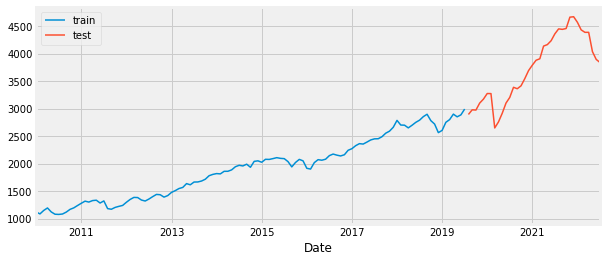

In [8]:
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

In [9]:
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")

Train dates : 2010-01-31 00:00:00 --- 2019-07-31 00:00:00  (n=115)


In [10]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-01-31 00:00:00'), Timestamp('2019-07-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: M 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-07-21 08:04:59 
Last fit date: 2022-07-21 08:04:59 
Skforecast version: 0.4.3 

In [11]:
Steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2019-08-31    2895.190160
2019-09-30    2909.192186
2019-10-31    2897.214863
2019-11-30    2897.499386
2019-12-31    2895.830041
Freq: M, Name: pred, dtype: float64

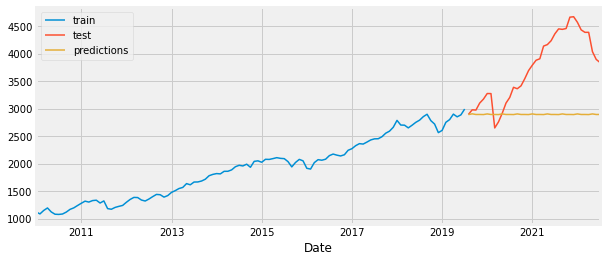

In [12]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()

In [13]:
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1072908.9463292637


In [14]:
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:16<00:00,  8.33s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 69472.78302477972



In [15]:
results_grid

,lags,params,metric,max_depth,n_estimators
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",69472.783025,5,500
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",69681.355147,10,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",70122.059069,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",70344.327532,10,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",77259.185312,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",79226.190819,10,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",79334.777056,5,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",80831.175891,10,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",83109.497348,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",83549.250072,3,100


In [16]:
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['y'])

In [17]:
predictions = forecaster.predict(steps=steps)

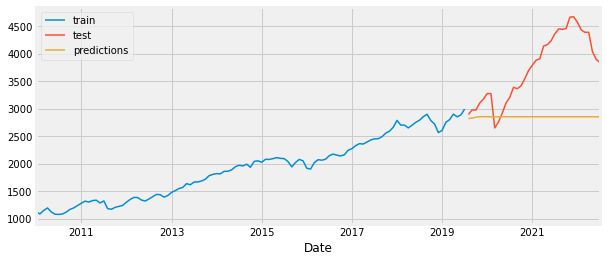

In [18]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [19]:
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
                )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1148042.4088592175


In [20]:
steps = 36
n_backtesting = 36*3 # The last 9 years are separated for the backtest

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    initial_train_size = len(data) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                                    )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 43
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   2010-01-31 00:00:00 -- 2013-07-31 00:00:00
    Validation: 2013-08-31 00:00:00 -- 2016-07-31 00:00:00
Data partition in fold: 1
    Training:   2010-01-31 00:00:00 -- 2016-07-31 00:00:00
    Validation: 2016-08-31 00:00:00 -- 2019-07-31 00:00:00
Data partition in fold: 2
    Training:   2010-01-31 00:00:00 -- 2019-07-31 00:00:00
    Validation: 2019-08-31 00:00:00 -- 2022-07-31 00:00:00

Backtest error: 546210.5245215002


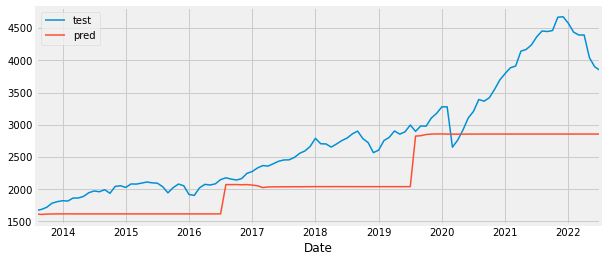

In [21]:
fig, ax = plt.subplots(figsize=(9, 4))
data.loc[predictions_backtest.index, 'y'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend()

In [22]:
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.215485
1,lag_2,0.060586
2,lag_3,0.052398
3,lag_4,0.104679
4,lag_5,0.199872
5,lag_6,0.095882
6,lag_7,0.048919
7,lag_8,0.035471
8,lag_9,0.024696
9,lag_10,0.028288
